<a href="https://colab.research.google.com/github/wojiushilr/data_hub/blob/master/assignment_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 課題：良品学習を用いた異常検知
- 【washer_ok】＝学習用良品画像
- 【washer_ng】＝検証用異常画像

#### Requirements
- washer_okに入っている画像のみを用いて良品学習を行ってください。
　良品学習はNGデータを使わずにGoodのデータのみを用いて異常検知を行う手法です。
- 良品学習のアルゴリズムはオートエンコーダー（VAE、GAN）などで構いません。複数のアルゴリズムで挑戦していればなお良いです。
- 良品画像、washer_ngの中にある異常画像を用いて、推論を行い、 異常度・異常箇所のヒートマップを出力してください。
- 上記結果・学習環境と1枚あたりの推論時間などをまとめて簡単なレポートにまとめてください。
- フレームワークはPytorchを推奨致します。

### VAE（Variational Autoencoder）

##### Config設定


In [17]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from pprint import pprint
import cv2
#---
# config
#---
cfg = EasyDict()

# class
# cfg.CLASS_LABEL = range(10) # list, dict('label' : '[B, G, R]')
# cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 900
cfg.INPUT_WIDTH = 900
cfg.INPUT_CHANNEL = 1
cfg.INPUT_MODE = "GRAY" # None, RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_HEIGHT = 900
cfg.OUTPUT_WIDTH = 900
cfg.OUTPUT_CHANNEL = 1
cfg.OUTPUT_MODE = None  # RGB, GRAY, EDGE, CLASS_LABEL
cfg.OUTPUT_CMAP = 'gray' # matplotlib cmap  (default : None)

# AE config
cfg.VAE_Z_DIM = 2
cfg.AE_DIM = 32 # AE encodes feature to this
cfg.VAE_KLD_BALANCE = 1 # loss = lossReconstruction + this * loss_KLD

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)

# train
cfg.TRAIN = EasyDict()

cfg.PREFIX = 'VAE'
cfg.TRAIN.MODEL_E_SAVE_PATH = 'models/' + cfg.PREFIX + '_E_{}.pt' # save model to this path
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt' # save model to this path
cfg.TRAIN.MODEL_SAVE_INTERVAL = 3000 # save model in each this
cfg.TRAIN.ITERATION = 3000 # max training iteration
cfg.TRAIN.MINIBATCH = 128
cfg.TRAIN.OPTIMIZER = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.001, 'weight_decay' : 1e-5}

cfg.TRAIN.DATA_PATH = "/content/washer/washer_ok" # use this dataset path
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.DISPLAY_ITERATION_INTERVAL = 1000
cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL = 10 # save loss in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW = 1000 # integer , False (not show)
cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True # save result image and loss text
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 1000 # save image and loss text in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'


# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_E_PATH = cfg.TRAIN.MODEL_E_SAVE_PATH.format('final') # use this trained path
cfg.TEST.MODEL_D_PATH = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final') # use this trained path
cfg.TEST.DATA_PATH = "/content/washer/washer_ng" # use this dataset path
cfg.TEST.MINIBATCH = 10
cfg.TEST.MAX_SAMPLES = 30
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)

# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_E_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)

pprint(cfg)

{'AE_DIM': 32,
 'CHANNEL_AXIS': 1,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'GPU': True,
 'INPUT_CHANNEL': 1,
 'INPUT_HEIGHT': 900,
 'INPUT_MODE': 'GRAY',
 'INPUT_WIDTH': 900,
 'OUTPUT_CHANNEL': 1,
 'OUTPUT_CMAP': 'gray',
 'OUTPUT_HEIGHT': 900,
 'OUTPUT_MODE': None,
 'OUTPUT_WIDTH': 900,
 'PREFIX': 'VAE',
 'TEST': {'DATA_PATH': '/content/washer/washer_ng',
          'ITERATION': 2,
          'MAX_SAMPLES': 30,
          'MINIBATCH': 10,
          'MODEL_D_PATH': 'models/VAE_D_final.pt',
          'MODEL_E_PATH': 'models/VAE_E_final.pt',
          'RESULT_IMAGE_PATH': 'result/VAE_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': '/content/washer/washer_ok',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
           'DISPLAY_ITERATION_INTERVAL': 1000,
           'ITERATION': 10000,
           'LEARNING_PARAMS': {'lr': 0.001, 'weight_decay': 1e-05},
           'LEARNING_PROCESS_PROG

#### データ関連

##### データセット取得

In [5]:
! git clone https://github.com/wojiushilr/data_hub.git

Cloning into 'data_hub'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
! unzip /content/data_hub/washer.zip

##### データ読み込み

In [2]:
def readfile(paths):
  img_num = 0
  x_all = None
  for n, path in enumerate(paths):
    img_dir = sorted(os.listdir(path))
    print(path)
    x = np.zeros((len(img_dir),cfg.INPUT_HEIGHT,cfg.INPUT_WIDTH,cfg.INPUT_CHANNEL),dtype = np.uint8)
    for i , file in enumerate(img_dir):
        if "jpg" not in file:
          print("Data format incorrect.", file)
          pass
        else:
          img = cv2.imread(os.path.join(path,file))
          img = cv2.resize(img, (cfg.INPUT_HEIGHT,cfg.INPUT_WIDTH)).astype(np.float32)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          img = np.expand_dims(img, axis=-1)
          x[i] = img
    if n == 0:
      x_all = x
    else:
      x_all = np.concatenate((x_all, x), axis=0)
  return x_all

In [3]:
train_workspace_dir = cfg.TRAIN.DATA_PATH
val_workspace_dir = cfg.TEST.DATA_PATH
print("Reading data")
train_x_raw = readfile([train_workspace_dir])
print("Size of training data = {}".format(len(train_x_raw)))
val_x_raw = readfile([(val_workspace_dir+"/kizu"), 
                  (val_workspace_dir+"/sabi"),
                  (val_workspace_dir+"/sure")])
print("Size of validation data = {}".format(len(val_x_raw)))
# test_x = readfile(os.path.join(workspace_dir,'testing'),False)
# print("Size of Testing data = {}".format(len(test_x)))

Reading data
/content/washer/washer_ok
Size of training data = 30
/content/washer/washer_ng/kizu
/content/washer/washer_ng/sabi
/content/washer/washer_ng/sure
Size of validation data = 82


##### np.arrayから画像生成

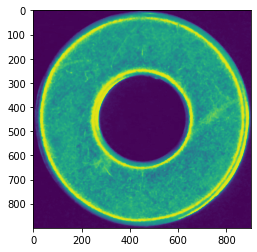

In [4]:
import matplotlib.pyplot as plt
plt.imshow(val_x_raw[70].reshape(cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))

##### 画像の切り出し

In [5]:
# 96*96のサイズに切り出す関数 (900*900から)
def cut_img(x, number, height=96, width=96):
    print("cutting images ...")
    x_out = []
    for i in range(number):
        shape_0 = np.random.randint(0,x.shape[0])
        shape_1 = np.random.randint(0,x.shape[1]-height)
        shape_2 = np.random.randint(0,x.shape[2]-width)
        #print(shape_0, shape_1, shape_2)
        temp = x[shape_0, shape_1:shape_1+height, shape_2:shape_2+width, 0]
        x_out.append(temp.reshape((1, 96, 96)))
    print("Complete.")
    x_out = np.array(x_out)
    print("x_out.shape: ", x_out.shape)
 
    return x_out

##### データセット作成

In [6]:
from torch.utils.data import DataLoader,Dataset,IterableDataset
train_set = cut_img(train_x_raw, 100000)
print("train data:",len(train_set))

cutting images ...
Complete.
x_out.shape:  (100000, 1, 96, 96)
train data: 100000


In [7]:
train_set[0]

array([[[207, 197, 191, ..., 154, 151, 150],
        [218, 211, 203, ..., 155, 152, 152],
        [231, 229, 222, ..., 157, 155, 155],
        ...,
        [ 12,  12,  11, ..., 165, 159, 155],
        [ 11,  11,   9, ..., 173, 165, 160],
        [ 10,  10,   8, ..., 179, 171, 166]]], dtype=uint8)

In [8]:
class BatchGenerator():
  def __init__(self, data_size, batch_size, shuffle=True):
      self.data_size = data_size
      self.batch_size = batch_size
      self.shuffle = shuffle
      self.mbi = 0 # index for iteration
      self.inds = np.arange(data_size)
      if shuffle:
          np.random.shuffle(self.inds)

  def __call__(self):
      if self.mbi + self.batch_size >= self.data_size:
          inds = self.inds[self.mbi:]
          if self.shuffle:
              np.random.shuffle(self.inds)
          inds = np.hstack((inds, self.inds[ : (self.batch_size - (self.data_size - self.mbi))]))
          self.mbi = self.batch_size - (self.data_size - self.mbi)
      else:
          inds = self.inds[self.mbi : self.mbi + self.batch_size]
          self.mbi += self.batch_size
      return inds
batch_gen = BatchGenerator(100000, cfg.TRAIN.MINIBATCH)

In [9]:
#ds = torchvision.datasets.MNIST(root="/content" , train=True, download=True, transform=None)
train_set = torch.tensor(train_set, dtype=torch.float).to(cfg.DEVICE)
val_set = torch.tensor(val_x_raw, dtype=torch.float).to(cfg.DEVICE)
train_set = train_set / 127.5 - 1
val_set = val_set / 127.5 - 1
# ts_data = torch.tensor(ds.targets, dtype=torch.long).to(cfg.DEVICE)
data_num = len(train_set)
print("train set len: ", data_num)
print("val set len: ", len(val_set))

train set len:  100000
val set len:  82


In [10]:
train_set.size()

torch.Size([100000, 1, 96, 96])

#### model 作成

In [25]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        # x = x.view(x.size()[0], -1)
        x = x.reshape(x.shape[0], -1)
        return x

class VAE_Encoder(torch.nn.Module):
    def __init__(self):
        super(VAE_Encoder, self).__init__()
        dim = cfg.AE_DIM

        self.module = torch.nn.Sequential(
            Flatten(),
            torch.nn.Linear(96 * 96 * cfg.INPUT_CHANNEL, dim * 8),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 8, dim * 4),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 4, dim * 2),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 2, dim),
            torch.nn.ReLU(),
        )

        self.encoder_mu = torch.nn.Linear(dim, cfg.VAE_Z_DIM)
        self.encoder_sigma = torch.nn.Linear(dim, cfg.VAE_Z_DIM)
        
    def forward(self, x):
        x = self.module(x)
        mu = self.encoder_mu(x)
        sigma = self.encoder_sigma(x)
        return mu, sigma
    
    
class VAE_Sampler(torch.nn.Module):
    def __init__(self):
        super(VAE_Sampler, self).__init__()
        
    def forward(self, x):
        mu, logvar = x
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
class VAE_Decoder(torch.nn.Module):
    def __init__(self):
        super(VAE_Decoder, self).__init__()
        dim = cfg.AE_DIM

        self.module = torch.nn.Sequential(
            torch.nn.Linear(cfg.VAE_Z_DIM, dim),
            torch.nn.ReLU(),
            torch.nn.Linear(dim, dim * 2),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 2, dim * 4),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 4, dim * 8),
            torch.nn.ReLU(),
            torch.nn.Linear(dim * 8, 96 * 96 * cfg.OUTPUT_CHANNEL),
            torch.nn.Sigmoid(),
        )
        self.encoder_mu = torch.nn.Linear(96 * 96 * cfg.OUTPUT_CHANNEL, 96 * 96 * cfg.INPUT_CHANNEL)
        self.encoder_sigma = torch.nn.Linear(96 * 96 * cfg.OUTPUT_CHANNEL, 96 * 96 * cfg.INPUT_CHANNEL)
        
    def forward(self, x):
        x = self.module(x)
        mu_d = self.encoder_mu(x)
        sigma_d = self.encoder_sigma(x)
        return x, mu_d, sigma_d
        # return self.module(x)

def loss_KLDivergence(mu, logvar):
  return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

### Train

##### summary of model

In [26]:
from torchsummary import summary
model_encoder = VAE_Encoder().to(cfg.DEVICE)
model_sampler = VAE_Sampler().to(cfg.DEVICE)
model_decoder = VAE_Decoder().to(cfg.DEVICE)
summary(model_encoder, (cfg.INPUT_CHANNEL, 96, 96), device=cfg.DEVICE_TYPE)
summary(model_decoder, (cfg.VAE_Z_DIM, ),  device=cfg.DEVICE_TYPE)

# from torchsummary import summary
# model = VAE().to(cfg.DEVICE)
# summary(model, (cfg.INPUT_CHANNEL, 96, 96), device=cfg.DEVICE_TYPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 9216]               0
            Linear-2                  [-1, 256]       2,359,552
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 2]              66
           Linear-11                    [-1, 2]              66
Total params: 2,402,916
Trainable params: 2,402,916
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forw

In [27]:
def result_show(Xs, ys, path=None, save=False, show=False, figsize=(12, 4), cmap=None):
    _Xs = Xs.detach().cpu().numpy()
    _Xs = (_Xs * 127.5 + 127.5).astype(np.uint8)
    
    ys = ys.detach().cpu().numpy()
    ys = (ys * 127.5 + 127.5).astype(np.uint8)
    ys = ys.reshape([-1, 1, 96, 96])
    
    if cfg.OUTPUT_CHANNEL == 1:
        _Xs = _Xs[:, 0]
        ys = ys[:, 0]
    else:
        _Xs = _Xs.transpose(0, 2, 3, 1)
        ys = ys.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(ys))
        
    plt.figure(figsize=figsize)
    for i in range(show_max):
        # show input
        _X = _Xs[i]
        plt.subplot(2, show_max, i + 1)
        plt.imshow(_X, cmap=cmap)
        plt.axis('off')
        plt.title('Input{}'.format(i + 1))
        
        # show output
        _y = ys[i]
        plt.subplot(2, show_max, i + 1 + show_max)
        plt.imshow(_y, cmap=cmap)
        plt.axis('off')
        plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

##### Train start

In [28]:
cfg.DEVICE

device(type='cuda')

training start
Iter:1000, Loss:298872.5938 (Recon:297841.7500, KLD:1030.8569)


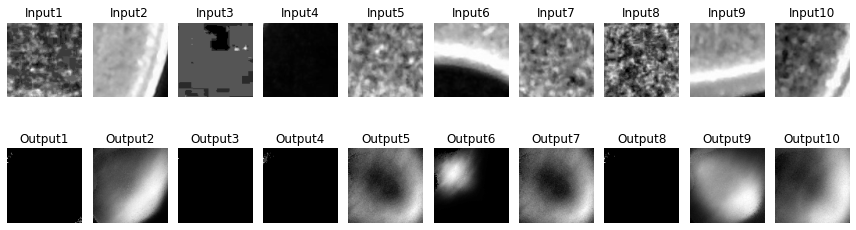

result was saved to >> result/VAE_result_iter1000.jpg
Iter:2000, Loss:352663.0938 (Recon:351581.5312, KLD:1081.5710)


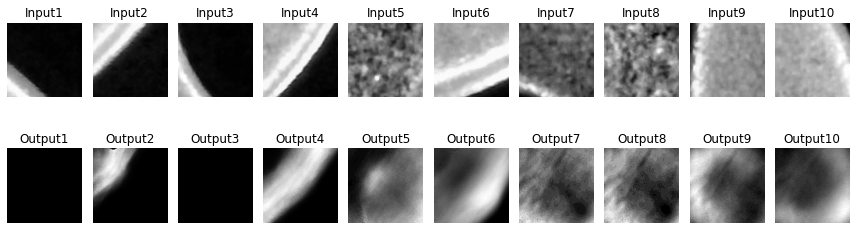

result was saved to >> result/VAE_result_iter2000.jpg
Iter:3000, Loss:367023.8125 (Recon:365999.6250, KLD:1024.1719)


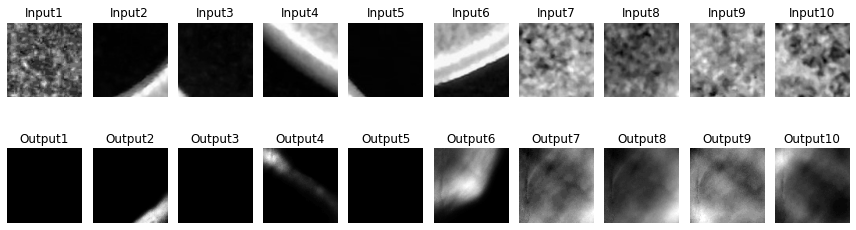

result was saved to >> result/VAE_result_iter3000.jpg
Iter:4000, Loss:354036.6875 (Recon:353064.9375, KLD:971.7648)


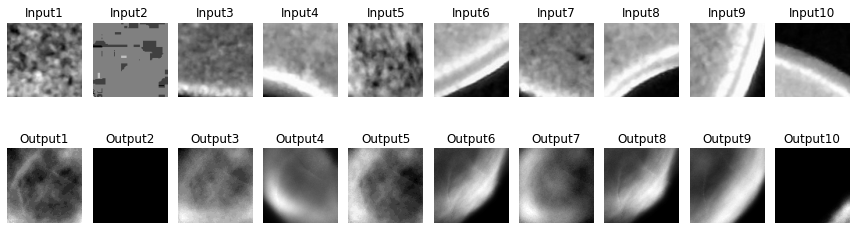

result was saved to >> result/VAE_result_iter4000.jpg
Iter:5000, Loss:321580.5938 (Recon:320215.4062, KLD:1365.1965)


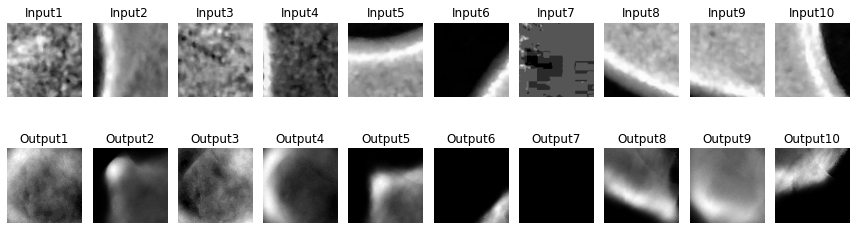

result was saved to >> result/VAE_result_iter5000.jpg
Iter:6000, Loss:323097.0312 (Recon:322032.1875, KLD:1064.8450)


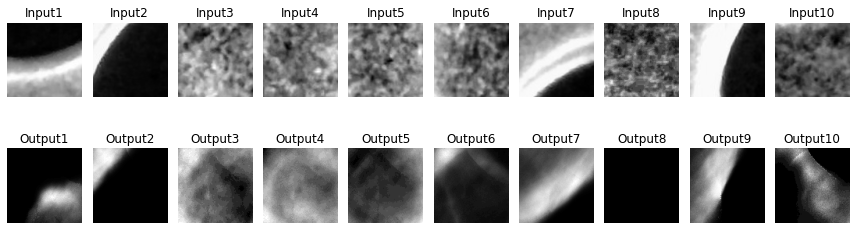

result was saved to >> result/VAE_result_iter6000.jpg
Iter:7000, Loss:346522.2812 (Recon:345448.8125, KLD:1073.4753)


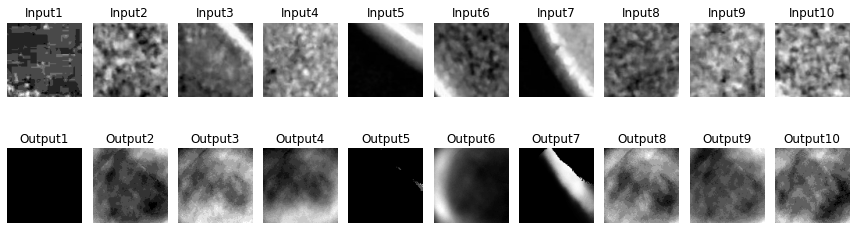

result was saved to >> result/VAE_result_iter7000.jpg
Iter:8000, Loss:317836.0625 (Recon:316710.9688, KLD:1125.1046)


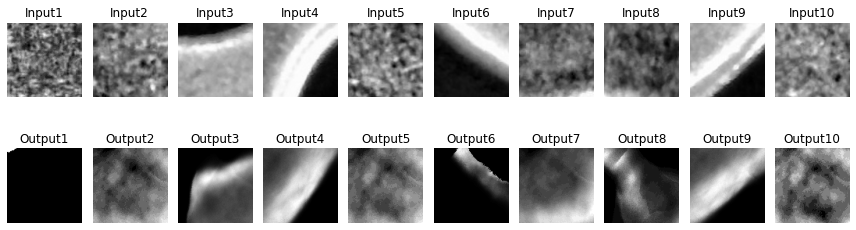

result was saved to >> result/VAE_result_iter8000.jpg
Iter:9000, Loss:295467.5938 (Recon:294309.4375, KLD:1158.1497)


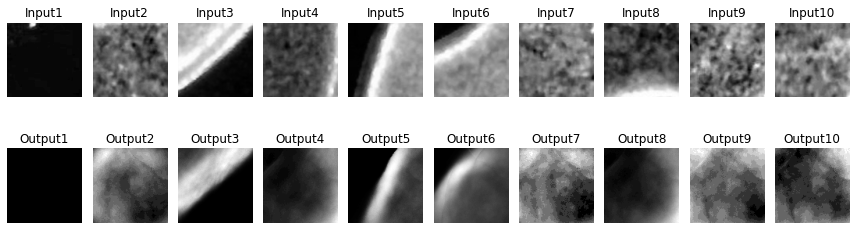

result was saved to >> result/VAE_result_iter9000.jpg
Iter:10000, Loss:237782.8281 (Recon:236648.1562, KLD:1134.6694)
save E >> models/VAE_E_iter10000.pt, D >> models/VAE_D_iter10000.pt


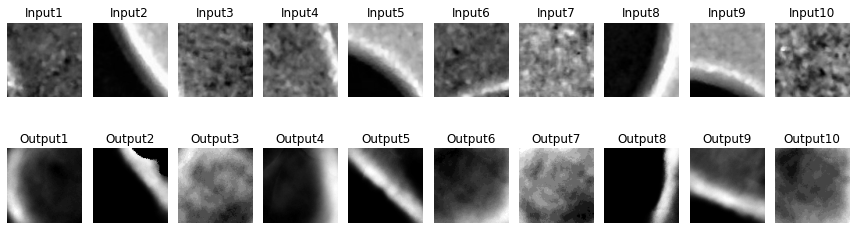

result was saved to >> result/VAE_result_iter10000.jpg
final paramters were saved toE >> models/VAE_E_final.pt, D >> models/VAE_D_final.pt
loss was saved to >> result/VAE_loss.txt


In [30]:
# model = VAE().to(cfg.DEVICE)
model = torch.nn.Sequential(model_encoder, model_sampler, model_decoder)
opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)
batch_gen = BatchGenerator(data_num, cfg.TRAIN.MINIBATCH)
loss_fn = torch.nn.MSELoss(reduction='sum')
list_iter = []
list_loss = []
list_loss_RECONSTRUCTION = []
list_loss_KLD = []
print('training start')
progres_bar = ''
model.train() 
for i in range(cfg.TRAIN.ITERATION):
  # get mini-batch indexs
  mb_inds = batch_gen()
  Xs = train_set[mb_inds]
  # train
  opt.zero_grad()
  
  # forward
  mu, sigma = model_encoder.forward(Xs)
  z = model_sampler.forward([mu, sigma])
  ys, mu_d, sigma_d= model_decoder.forward(z)
  # ys = model_decoder.forward(z)
  # loss
  loss_recon = loss_fn(ys, Xs.view(cfg.TRAIN.MINIBATCH, -1))
  # loss KLDivergence
  loss_kld = loss_KLDivergence(mu, sigma)
  loss = loss_recon + cfg.VAE_KLD_BALANCE * loss_kld
  # update
  loss.backward()
  opt.step()
  progres_bar += '|'

  _loss = loss.item()
  _loss_recon = loss_recon.item()
  _loss_kld = loss_kld.item()

  if (i+ 1) % cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL == 0:
    progres_bar += str(i + 1)
    # save process result
    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
      list_iter.append(i + 1)
      list_loss.append(_loss)
      list_loss_RECONSTRUCTION.append(_loss_recon)
      list_loss_KLD.append(_loss_kld)
  print('\r' + 'Loss:{:.4f} '.format(_loss) +" - "+progres_bar, end='')
  # display training state
  if (i + 1) % cfg.TRAIN.DISPLAY_ITERATION_INTERVAL == 0:
    print('\r' + ' ' * len(progres_bar), end='')
    print('\rIter:{}, Loss:{:.4f} (Recon:{:.4f}, KLD:{:.4f})'.format(i + 1, _loss, _loss_recon, _loss_kld))
    progres_bar = ''

  # save parameters
  if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
    save_path_E = cfg.TRAIN.MODEL_E_SAVE_PATH.format('iter{}'.format(i + 1))
    save_path_D = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
    torch.save(model_encoder.state_dict(), save_path_E)
    torch.save(model_decoder.state_dict(), save_path_D)
    print('save E >> {}, D >> {}'.format(save_path_E, save_path_D))

  # show process result
  if (cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW != False) and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW == 0):
    result_show(
        Xs, ys, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
        save=False, show=True, cmap=cfg.OUTPUT_CMAP)
      
  # save process result
  if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
    result_show(
        Xs, ys, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
        save=True, show=False, cmap=cfg.OUTPUT_CMAP)
save_path_E = cfg.TRAIN.MODEL_E_SAVE_PATH.format('final') 
save_path_D = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
torch.save(model_encoder.state_dict(), save_path_E)
torch.save(model_decoder.state_dict(), save_path_D)
print('final paramters were saved toE >> {}, D >> {}'.format(save_path_E, save_path_D))
if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
  f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
  df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'loss_reconstruction' : list_loss_RECONSTRUCTION, 
                      'loss_KLD' : list_loss_KLD})
  df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
  print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

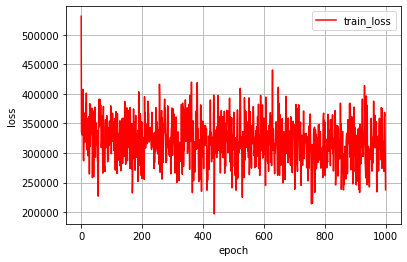

In [31]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(cfg.TRAIN.ITERATION//cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL), list_loss, 'r-', label='train_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

### ヒートマップ

##### 画像生成モジュール

In [41]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os

def save_img(x_normal, x_anomaly, img_normal, img_anomaly, name):
    path = 'images/'
    if not os.path.exists(path):
          os.mkdir(path)

    img_max = np.max([img_normal, img_anomaly])
    img_min = np.min([img_normal, img_anomaly])
    img_normal = (img_normal-img_min)/(img_max-img_min) * 9 + 1
    img_anomaly = (img_anomaly-img_min)/(img_max-img_min) * 9 + 1

    plt.figure()
    plt.subplot(2, 2, 1)
    plt.imshow(x_normal[:,:], cmap='gray')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.imshow(img_normal[:,:], cmap='Blues',norm=colors.LogNorm())
    plt.axis('off')
    plt.colorbar()
    plt.clim(1, 10)

    plt.title(name + "normal")

    plt.subplot(2, 2, 3)
    plt.imshow(x_anomaly[:,:], cmap='gray')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.imshow(img_anomaly[:,:], cmap='Blues',norm=colors.LogNorm())
    plt.axis('off')
    plt.colorbar()
    plt.clim(1, 10)

    plt.title(name + "anomaly")

    plt.savefig(path + name +".png")
    plt.show()
    plt.close()


##### ヒートマップの計算モジュール

In [77]:
#ヒートマップの計算
def evaluate_img(model, x_normal, x_anomaly, name, height=96, width=96, move=20):
    img_normal = np.zeros((x_normal.shape))
    img_anomaly = np.zeros((x_anomaly.shape))
    print("img_normal shape: ", img_normal.shape)
    print("img_anomaly shape: ", img_anomaly.shape)
 
    for i in range(int((x_normal.shape[0]-height)/move)):
        for j in range(int((x_normal.shape[1]-width)/move)):
            x_sub_normal = x_normal[i*move:i*move+height, j*move:j*move+width]
            x_sub_anomaly = x_anomaly[i*move:i*move+height, j*move:j*move+width]
            x_sub_normal = x_sub_normal.reshape(1, 1, height, width)
            x_sub_anomaly = x_sub_anomaly.reshape(1, 1, height, width)
            # print(x_sub_normal.shape)
            #従来手法
            if name == "old_":
                #正常のスコア
                with torch.no_grad():
                  normal_score,mu, sigma = model(x_sub_normal)
                  normal_score = normal_score.reshape(96,96).to('cpu').detach().numpy().copy()
                img_normal[i*move:i*move+height, j*move:j*move+width] +=  normal_score
 
                #異常のスコア
                with torch.no_grad():
                  anomaly_score,mu, sigma = model(x_sub_anomaly)
                  anomaly_score = anomaly_score.reshape(96,96).to('cpu').detach().numpy().copy()
                img_anomaly[i*move:i*move+height, j*move:j*move+width] +=  anomaly_score
 
            #NEW手法 # https://confit.atlas.jp/guide/event-img/jsai2018/2A1-03/public/pdf?type=in
            else:
                #正常のスコア
                with torch.no_grad():
                  y, mu, sigma = model(x_sub_normal)
                  mu = mu.reshape(96,96).to('cpu').detach().numpy().copy()
                  sigma = sigma.reshape(96,96).to('cpu').detach().numpy().copy()
                  x_sub_normal = x_sub_normal.reshape(96,96).to('cpu').detach().numpy().copy()
                loss = 0
                for k in range(height):
                    for l in range(width):
                        # print("l: ", l)
                        # print(x_sub_normal[k,l])
                        # print((mu[k,l])**2)
                        loss += 0.5 * (x_sub_normal[k,l] - mu[k,l])**2 / sigma[k,l]
                img_normal[i*move:i*move+height, j*move:j*move+width] +=  loss
 
                #異常のスコア
                with torch.no_grad():
                  y, mu, sigma = model(x_sub_anomaly)
                  mu = mu.reshape(96,96).to('cpu').detach().numpy().copy()
                  sigma = sigma.reshape(96,96).to('cpu').detach().numpy().copy()
                  x_sub_anomaly = x_sub_anomaly.reshape(96,96).to('cpu').detach().numpy().copy()
                loss = 0
                for k in range(height):
                    for l in range(width):
                        loss += 0.5 * (x_sub_anomaly[k,l] - mu[k,l])**2 / sigma[k,l]
                img_anomaly[i*move:i*move+height, j*move:j*move+width] +=  loss

    x_normal = x_normal.to('cpu').detach().numpy().copy()
    x_anomaly = x_anomaly.to('cpu').detach().numpy().copy()
    save_img(x_normal, x_anomaly, img_normal, img_anomaly, name)

In [52]:
# varify output of model
temp_normal = train_set[0].reshape(1, 1, 96, 96)
temp_normal.shape

torch.Size([1, 1, 96, 96])

In [45]:
PATH_E = "/content/models/VAE_E_final.pt"
PATH_D = "/content/models/VAE_D_final.pt"
model_encoder = VAE_Encoder().to(cfg.DEVICE)
model_sampler = VAE_Sampler().to(cfg.DEVICE)
model_decoder = VAE_Decoder().to(cfg.DEVICE)
model_encoder.load_state_dict(torch.load(PATH_E))
model_decoder.load_state_dict(torch.load(PATH_D))
model = torch.nn.Sequential(model_encoder, model_sampler, model_decoder)
with torch.no_grad():
  y, mu_d, sigma_d = model(temp_normal)
print(mu_d.size(), sigma_d.size())

torch.Size([1, 9216]) torch.Size([1, 9216])


In [79]:
train_raw_set = torch.tensor(train_x_raw, dtype=torch.float).to(cfg.DEVICE)
x_normal = train_raw_set[0].reshape(900, 900)
print(x_normal.shape)
x_anomaly = val_set[56].reshape(900, 900)
print(x_anomaly.shape)

torch.Size([900, 900])
torch.Size([900, 900])


img_normal shape:  (900, 900)
img_anomaly shape:  (900, 900)


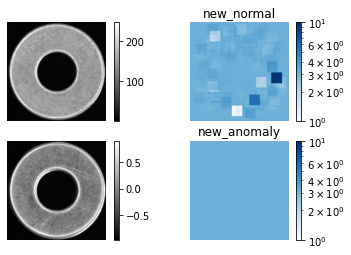

In [78]:
test_img = evaluate_img(model, x_normal, x_anomaly, name = "new_")

img_normal shape:  (900, 900)
img_anomaly shape:  (900, 900)


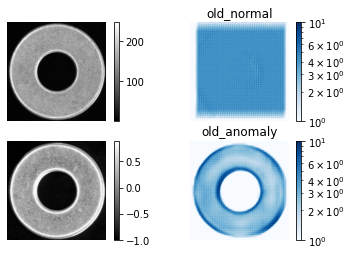

In [80]:
test_img = evaluate_img(model, x_normal, x_anomaly, name = "old_")

### Some varify code

In [66]:
# insepct the val_set and train_set
print(val_set.size())
print(train_set.size())

torch.Size([82, 900, 900, 1])
torch.Size([100000, 1, 96, 96])


In [99]:
# varify output of model
temp_normal = train_set[0].reshape(1, 1, 96, 96)
temp_normal.shape

torch.Size([1, 1, 96, 96])

In [100]:
test_img.shape

torch.Size([1, 1, 96, 96])

In [103]:
PATH_E = "/content/models/VAE_E_final.pt"
PATH_D = "/content/models/VAE_D_final.pt"
model_encoder = VAE_Encoder().to(cfg.DEVICE)
model_sampler = VAE_Sampler().to(cfg.DEVICE)
model_decoder = VAE_Decoder().to(cfg.DEVICE)
model_encoder.load_state_dict(torch.load(PATH_E))
model_decoder.load_state_dict(torch.load(PATH_D))
model = torch.nn.Sequential(model_encoder, model_sampler, model_decoder)
with torch.no_grad():
  output = model(test_img)
output.size()

torch.Size([1, 9216])

In [44]:
import numpy as np
 
# 5行5列のデータを作成
x = np.arange(25).reshape(5, 5)
print(x);print()
y = x[:, 1] # 第一列を取得する
print(y)
 
# (1, 5, 5, 1)にリシェイプ
x = x.reshape(1, 5, 5, 1)
# print(x);print()
 
# 2行3列を切り出す
x = x[0, 0, 1, 0]
print(x)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]

[ 1  6 11 16 21]
1
